In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models.Wang2020 import M2_1
net = M2_1(N_layers=8, width=32, activation=nn.ELU()).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
#train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

ImplicitDataset (195112 points)


In [5]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=0.1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [6]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 25000
PRINT_EVERY_EPOCH = 1000
epoch = 0
try:
    while epoch < max_epochs:
        # Training
        for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=20000): 
            optimizer.zero_grad()
            points.requires_grad_(True)
            y = net(points)
            loss = net.loss(y, points, points, sdfs)
            loss.backward()
      
            lr_scheduler.optimizer.step(lambda: loss)
            lr_scheduler.step_when((epoch % 5000) == 4999)
            lr_scheduler.step_loss(loss)
        
            if epoch % 200 == 199:
                y = net(points)
                net.adaptive_lambda(y, points, points, sdfs)

            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda[0]:.6f}')
            epoch += 1
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.993070, 0.121570, 1.000000
#1000 Loss: 0.222773, 0.024563, 6.682240
#2000 Loss: 0.223955, 0.017151, 10.129599
#3000 Loss: 0.174990, 0.009157, 12.223612
#4000 Loss: 0.155742, 0.006290, 15.973876
#5000 Loss: 0.243857, 0.010453, 14.769028
#6000 Loss: 0.080301, 0.004383, 11.137634
#7000 Loss: 0.063065, 0.003926, 9.543200
#8000 Loss: 0.048115, 0.003295, 8.570545
#9000 Loss: 0.035277, 0.002762, 7.891540
#10000 Loss: 0.027506, 0.002435, 6.812519
#11000 Loss: 0.021172, 0.002228, 5.737295
#12000 Loss: 0.019010, 0.002205, 5.158650
#13000 Loss: 0.017271, 0.002163, 4.767347
#14000 Loss: 0.015663, 0.002121, 4.392548
#15000 Loss: 0.014220, 0.002087, 4.013131
#16000 Loss: 0.012370, 0.001864, 3.605703
#17000 Loss: 0.011922, 0.001864, 3.365111
#18000 Loss: 0.011657, 0.001864, 3.223032
#19000 Loss: 0.011500, 0.001864, 3.139127
#20000 Loss: 0.011408, 0.001864, 3.089575
#21000 Loss: 0.011353, 0.001864, 3.060312
#22000 Loss: 0.011321, 0.001864, 3.043032
#23000 Loss: 0.011302, 0.001864, 3.032829


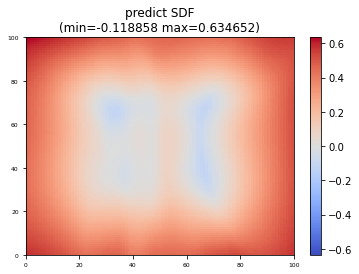

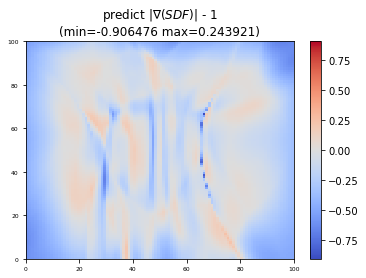

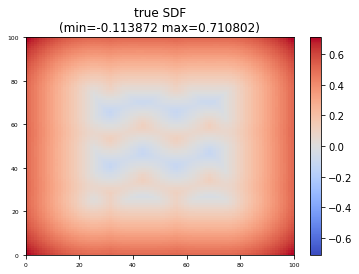

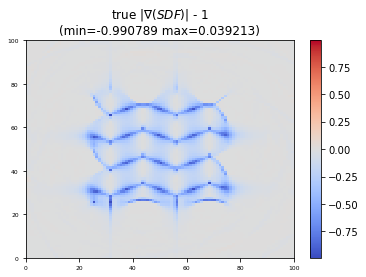

In [7]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)